<a href="https://colab.research.google.com/github/takaito1/EAS4821_S2024/blob/main/week9_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.5 MB/s eta 0:00:00


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats
import cartopy.crs as ccrs
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# loading Nino3.4 index
nino34 = np.genfromtxt('/content/drive/MyDrive/nino34.txt')

In [8]:
# loading air temperature data
ds = xr.open_dataset('/content/drive/MyDrive/EAS2655_4821/air.2m.mon.mean.nc')

In [61]:
def calc_Neff(X,Y):
    # lag1-autocorrelation for X
    tmp1=X[:-1]
    tmp2=X[1:]
    c=np.cov(tmp1,tmp2)
    r1=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    # lag1-autocorrelation for Y
    tmp1=Y[:-1]
    tmp2=Y[1:]
    c=np.cov(tmp1,tmp2)
    r2=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    # calculate Neff
    N=np.size(X)
    Neff = N*(1-r1*r2)/(1+r1*r2)
    if Neff > N:
        Neff = N
    return Neff

In [69]:
# define a function to calculate regression / correlation coefficients
def regrcorr(X,Y,CL):
    alp = 1-CL/100
    c=np.cov(X,Y)
    a=c[0,1]/c[0,0]
    b=np.mean(Y)-a*np.mean(X)
    r=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    Neff=calc_Neff(X,Y)
    MSE = np.sum(((a*X+b) - Y)**2)/(Neff-2)
    SEa = np.sqrt( MSE/np.sum((X-np.mean(X))**2) )
    SEr = np.sqrt( (1-r**2)/(Neff-2) )
    ta=np.abs(a)/SEa
    tr=np.abs(r)/SEr
    tcrit=stats.t.ppf(1-alp/2,Neff-2)
    if ta>tcrit:
        sig_a = 1
    else:
        sig_a = 0
    if tr>tcrit:
        sig_r = 1
    else:
        sig_r = 0
    return a,b,r,Neff,SEa,SEr,sig_a,sig_r

(76,)

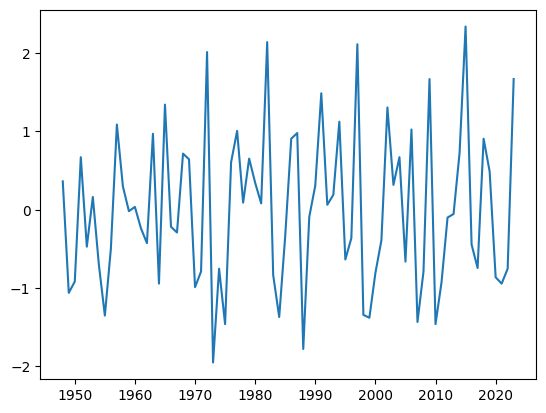

In [21]:
# preparing nino3.4 index data
#
year_nino = nino34[:,0]
dec_nino = nino34[:,12]
#plt.plot(year_nino,dec_nino)
after48 = (year_nino>=1948)
nino_0 = dec_nino[after48]
#plt.plot(year_nino[after48],nino_0)

# z-transform the nino34 index
nino_1 = (nino_0 - np.mean(nino_0))/np.std(nino_0)
plt.plot(year_nino[after48],nino_1)
nino_1.shape

In [63]:
X = nino_1
Y = ds.air[:,40,80].sel(time=(ds.time.dt.month==12)).to_numpy() - 273.15 # convert to degC

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [68]:
a,b,r,Neff,SEa,SEr,sig_a,sig_r = regrcorr(X,Y,95)
print(a,b,r,Neff,SEa,SEr,sig_a,sig_r)

-0.08604569629751678 27.410676956176758 -0.1998378131641928 76 0.049044002887850345 0.11390280638818683 False False


In [72]:
# loop over long and lat
Nx = ds.dims['lon']
Ny = ds.dims['lat']
output = np.zeros((8,Ny,Nx))
air = ds.air.sel(time=(ds.time.dt.month==12)).to_numpy()-273.15
for nx in range(Nx):
    for ny in range(Ny):
        Y=air[:,ny,nx]
        X = nino_1
        a,b,r,Neff,SEa,SEr,sig_a,sig_r = regrcorr(X,Y,95)
        output[0,ny,nx]=a
        output[1,ny,nx]=b
        output[2,ny,nx]=r
        output[3,ny,nx]=Neff
        output[4,ny,nx]=SEa
        output[5,ny,nx]=SEr
        output[6,ny,nx]=sig_a
        output[7,ny,nx]=sig_r

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


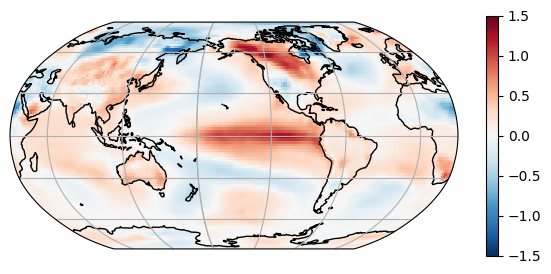

In [77]:
fig=plt.figure(figsize=(7,6))
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Robinson(central_longitude=-150))
im = ax.pcolormesh(ds.lon,ds.lat,output[0,:,:],cmap='RdBu_r',vmin=-1.5,vmax=1.5,
              transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.colorbar(im,ax=ax,location='right',shrink=.5)